In [24]:
!pip install facenet_pytorch

In [25]:
!pip install matplotlib

In [26]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn

import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import glob
import os
# from tensorflow.keras.models import load_model

# from tensorflow.keras.models import Model
import os
import warnings


from torch.utils.data import random_split
from torch.utils.data import DataLoader,Dataset
import torch.nn.functional as F
import torch.optim as optim



In [27]:

class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.gender_mapping = {'male': 0, 'female': 1}
        self.ethnicity_mapping = {'white': 0, 'black': 1, 'asian': 2, 'hispanic': 3}
        self.data['nameNum'] = self.data['name'].astype('category').cat.codes
        self.data['nameNum'] = self.data['nameNum'].astype(int)


    def __len__(self):
        return len(self.data)


    
    def getAgeLabel(self,value1):

    # Define class ranges
        class_ranges = [(15, 22),(22,40),(40,60),(60,80)]
    
    # Check if both values fall into the same class range
        if(class_ranges[0][0]<=value1 and value1<class_ranges[0][1]):
            return 0
        elif(class_ranges[1][0]<=value1 and value1<class_ranges[1][1]):
            return 1
        elif(class_ranges[2][0]<=value1 and value1<class_ranges[2][1]):
            return 2
        elif(class_ranges[3][0]<=value1 and value1<class_ranges[3][1]):
            return 3
        else:
            return 0
   

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = '/home/csgrad/kaushik3/PolyProtect/PolyProtect_HEAAN/Data/CELEBTEST/'+row['name']+'/' + row['filename']  # Assuming images are in a folder named 'images'
        
        try:
            image = Image.open(image_path)
        except Exception as e:
            # Handle the error, for example, you can return a placeholder image
            print("here")
            #self.__getitem__(idx + 1)
            #image = Image.new('RGB', (224, 224))  # Create a blank image
        
        image = Image.open(image_path)
        age = row['age']
        
        if(row['age']<=0):
            age=35
        label = {
            'age': self.getAgeLabel(age),
            'gender': self.gender_mapping.get(row['gender'], 0),  # -1 for unknown
            'ethnicity': self.ethnicity_mapping.get(row['ethnicity'], 0),
            'age1':age,
            'name': row['nameNum']
        
        }
        #print(row['name'])
        if self.transform:
            image = self.transform(image)

        return image, label


In [28]:
# csv_file = '/home/csgrad/byalavar/FHE/celebSet/celebSET_final_v1.csv'  # Replace with the actual path to your CSV file
# df = pd.read_csv(csv_file)

# # Create a list to store the indices of rows with missing files
# rows_to_remove = []
# count=0
# # Iterate through the DataFrame and check if the files exist
# for index, row in df.iterrows():
#     image_path = '/home/csgrad/byalavar/FHE/celebSet/CELEBTEST/CELEBTEST/'+row['name']+'/' + row['filename'] 
#     if not os.path.exists(image_path):
#         rows_to_remove.append(index)
#         count=count+1
# df = df.drop(rows_to_remove)
# df.to_csv(csv_file, index=False)
# print(count)

In [29]:
transform = transforms.Compose([
    transforms.Resize((112, 112)),  # Resize the image to the desired size
    transforms.ToTensor(),          # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])


In [30]:
trainSet = CustomDataset('/home/csgrad/kaushik3/PolyProtect/PolyProtect_HEAAN/celebSetIdentity.csv', transform=transform)
trainloader = DataLoader(trainSet, batch_size=16, shuffle=True, num_workers=2)

testSet = CustomDataset('/home/csgrad/kaushik3/PolyProtect/PolyProtect_HEAAN/celebSetIdentityTest.csv', transform=transform)
testloader = DataLoader(testSet, batch_size=16, shuffle=False, num_workers=2)


In [31]:
def imshow(img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        # print(npimg.shape)
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


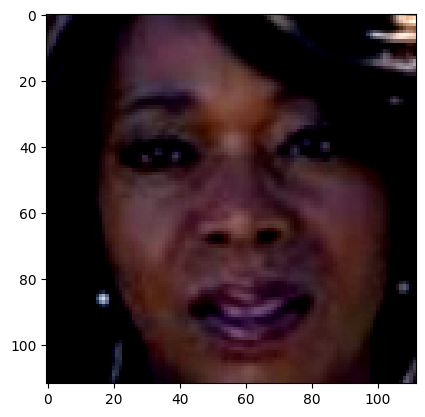

In [32]:
tempIter = iter(testloader)
# images,image_pairs = next(tempIter)
# imshow(images[0])
# print(labels['age'][0],labels['gender'][0],labels['ethnicity'][0])
# print(image_pairs)
image, label = next(tempIter)
imshow(image[0])
# imshow(image_pairs[0][0])

In [33]:
import torch
import torch.nn as nn
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, ReLU, Sigmoid, Dropout, MaxPool2d, \
    AdaptiveAvgPool2d, Sequential, Module
from collections import namedtuple


# Support: ['IR_50', 'IR_101', 'IR_152', 'IR_SE_50', 'IR_SE_101', 'IR_SE_152']


class Flatten(Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


def l2_norm(input, axis=1):
    norm = torch.norm(input, 2, axis, True)
    output = torch.div(input, norm)

    return output


class SEModule(Module):
    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = AdaptiveAvgPool2d(1)
        self.fc1 = Conv2d(
            channels, channels // reduction, kernel_size=1, padding=0, bias=False)

        nn.init.xavier_uniform_(self.fc1.weight.data)

        self.relu = ReLU(inplace=True)
        self.fc2 = Conv2d(
            channels // reduction, channels, kernel_size=1, padding=0, bias=False)

        self.sigmoid = Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)

        return module_input * x


class bottleneck_IR(Module):
    def __init__(self, in_channel, depth, stride):
        super(bottleneck_IR, self).__init__()
        if in_channel == depth:
            self.shortcut_layer = MaxPool2d(1, stride)
        else:
            self.shortcut_layer = Sequential(
                Conv2d(in_channel, depth, (1, 1), stride, bias=False), BatchNorm2d(depth))
        self.res_layer = Sequential(
            BatchNorm2d(in_channel),
            Conv2d(in_channel, depth, (3, 3), (1, 1), 1, bias=False), PReLU(depth),
            Conv2d(depth, depth, (3, 3), stride, 1, bias=False), BatchNorm2d(depth))

    def forward(self, x):
        shortcut = self.shortcut_layer(x)
        res = self.res_layer(x)

        return res + shortcut


class bottleneck_IR_SE(Module):
    def __init__(self, in_channel, depth, stride):
        super(bottleneck_IR_SE, self).__init__()
        if in_channel == depth:
            self.shortcut_layer = MaxPool2d(1, stride)
        else:
            self.shortcut_layer = Sequential(
                Conv2d(in_channel, depth, (1, 1), stride, bias=False),
                BatchNorm2d(depth))
        self.res_layer = Sequential(
            BatchNorm2d(in_channel),
            Conv2d(in_channel, depth, (3, 3), (1, 1), 1, bias=False),
            PReLU(depth),
            Conv2d(depth, depth, (3, 3), stride, 1, bias=False),
            BatchNorm2d(depth),
            SEModule(depth, 16)
        )

    def forward(self, x):
        shortcut = self.shortcut_layer(x)
        res = self.res_layer(x)

        return res + shortcut


class Bottleneck(namedtuple('Block', ['in_channel', 'depth', 'stride'])):
    '''A named tuple describing a ResNet block.'''


def get_block(in_channel, depth, num_units, stride=2):

    return [Bottleneck(in_channel, depth, stride)] + [Bottleneck(depth, depth, 1) for i in range(num_units - 1)]


def get_blocks(num_layers):
    if num_layers == 50:
        blocks = [
            get_block(in_channel=64, depth=64, num_units=3),
            get_block(in_channel=64, depth=128, num_units=4),
            get_block(in_channel=128, depth=256, num_units=14),
            get_block(in_channel=256, depth=512, num_units=3)
        ]
    elif num_layers == 100:
        blocks = [
            get_block(in_channel=64, depth=64, num_units=3),
            get_block(in_channel=64, depth=128, num_units=13),
            get_block(in_channel=128, depth=256, num_units=30),
            get_block(in_channel=256, depth=512, num_units=3)
        ]
    elif num_layers == 152:
        blocks = [
            get_block(in_channel=64, depth=64, num_units=3),
            get_block(in_channel=64, depth=128, num_units=8),
            get_block(in_channel=128, depth=256, num_units=36),
            get_block(in_channel=256, depth=512, num_units=3)
        ]

    return blocks


class Backbone(Module):
    def __init__(self, input_size, num_layers, mode='ir'):
        super(Backbone, self).__init__()
        assert input_size[0] in [112, 224], "input_size should be [112, 112] or [224, 224]"
        assert num_layers in [50, 100, 152], "num_layers should be 50, 100 or 152"
        assert mode in ['ir', 'ir_se'], "mode should be ir or ir_se"
        blocks = get_blocks(num_layers)
        if mode == 'ir':
            unit_module = bottleneck_IR
        elif mode == 'ir_se':
            unit_module = bottleneck_IR_SE
        self.input_layer = Sequential(Conv2d(3, 64, (3, 3), 1, 1, bias=False),
                                      BatchNorm2d(64),
                                      PReLU(64))
        if input_size[0] == 112:
            self.output_layer = Sequential(BatchNorm2d(512),
                                           Dropout(),
                                           Flatten(),
                                           Linear(512 * 7 * 7, 512),
                                           BatchNorm1d(512))
        else:
            self.output_layer = Sequential(BatchNorm2d(512),
                                           Dropout(),
                                           Flatten(),
                                           Linear(512 * 14 * 14, 512),
                                           BatchNorm1d(512))

        modules = []
        for block in blocks:
            for bottleneck in block:
                modules.append(
                    unit_module(bottleneck.in_channel,
                                bottleneck.depth,
                                bottleneck.stride))
        self.body = Sequential(*modules)

        self._initialize_weights()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.body(x)
        x = self.output_layer(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()


def IR_50(input_size):
    """Constructs a ir-50 model.
    """
    model = Backbone(input_size, 50, 'ir')

    return model


def IR_101(input_size):
    """Constructs a ir-101 model.
    """
    model = Backbone(input_size, 100, 'ir')

    return model


def IR_152(input_size):
    """Constructs a ir-152 model.
    """
    model = Backbone(input_size, 152, 'ir')

    return model


def IR_SE_50(input_size):
    """Constructs a ir_se-50 model.
    """
    model = Backbone(input_size, 50, 'ir_se')

    return model


def IR_SE_101(input_size):
    """Constructs a ir_se-101 model.
    """
    model = Backbone(input_size, 100, 'ir_se')

    return model


def IR_SE_152(input_size):
    """Constructs a ir_se-152 model.
    """
    model = Backbone(input_size, 152, 'ir_se')

    return model

In [34]:
arcFaceModel = IR_50([112,112])
arcFaceModel.load_state_dict(torch.load("/home/csgrad/kaushik3/PolyProtect/PolyProtect_HEAAN/Data/ArcFace/backbone_ir50_ms1m_epoch120.pth"))

<All keys matched successfully>

In [35]:
warnings.filterwarnings("ignore", category=DeprecationWarning)  # Ignore DeprecationWarnings
warnings.filterwarnings("ignore", category=FutureWarning) 
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

print('Running on device: {}'.format(device))

Running on device: cuda:1


In [36]:
trainSet.data['age'].min()

3

In [37]:
def get_normalized_age_value(original_age_value):
    return (original_age_value - trainSet.data['age'].min())/(trainSet.data['age'].max() - trainSet.data['age'].min())


def get_original_age_value(normalized_age_value):
    return normalized_age_value * (trainSet.data['age'].max()  - trainSet.data['age'].min()) + trainSet.data['age'].min()

In [44]:
from torch.nn.modules import MSELoss
from torch.nn.modules.loss import CrossEntropyLoss
from torch.nn.parallel import DataParallel

class GenderDet(nn.Module):
    def __init__(self, compression_size):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(compression_size,64),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,2)
        )
        
    def forward(self, x):
        return self.layer(x)

class AgeDet(nn.Module):
    def __init__(self, compression_size):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(compression_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 4)
        )
        
    def forward(self, x):
        return self.layer(x)
    
class EthnicityDet(nn.Module):
    def __init__(self, compression_size):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(compression_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
        
    def forward(self, x):
        return self.layer(x)
    
class IdentityDet(nn.Module):
    def __init__(self, compression_size):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(compression_size, 64), 
            nn.ReLU(), 
            nn.Linear(64, 80))
        
    def forward(self, x):
        return self.layer(x)
    

class Matryoshka_CE_Loss(nn.Module):
    def __init__(self, relative_importance = 1.0):
        super(Matryoshka_CE_Loss, self).__init__()
        self.criterion = nn.CrossEntropyLoss()
        self.relative_importance = relative_importance # usually set to all ones
    
    def forward(self, output, target):
        loss = 0
        for i in range(len(output)):
            # loss += self.relative_importance[i] * self.criterion(output[i], target)
            loss += self.relative_importance * self.criterion(output[i], target)
        return loss

class MRL_Linear_Layer(nn.Module):
    def __init__(self, nesting_list, num_classes=1000, efficient=False, **kwargs):
        super(MRL_Linear_Layer, self).__init__()
        self.nesting_list=nesting_list
        self.num_classes=num_classes # Number of classes for classification
        self.efficient = efficient
        if self.efficient:
            setattr(self, f"nesting_classifier_{0}", nn.Linear(nesting_list[-1], self.num_classes, **kwargs))		
        else:	
            for i, num_feat in enumerate(self.nesting_list):
                setattr(self, f"nesting_classifier_{i}", nn.Linear(num_feat, self.num_classes, **kwargs))	


    def forward(self, x):
        nesting_logits = ()
        for i, num_feat in enumerate(self.nesting_list):
            if self.efficient:
                if self.nesting_classifier_0.bias is None:
                    nesting_logits+= (torch.matmul(x[:, :num_feat], (self.nesting_classifier_0.weight[:, :num_feat]).t()), )
                else:
                    nesting_logits+= (torch.matmul(x[:, :num_feat], (self.nesting_classifier_0.weight[:, :num_feat]).t()) + self.nesting_classifier_0.bias, )
            else:
                nesting_logits +=  (getattr(self, f"nesting_classifier_{i}")(x[:, :num_feat]),)

        return nesting_logits

class MRL_Model(nn.Module):
    def __init__(self, compression_size, efficient=False):
        super(MRL_Model, self).__init__()
        self.ll1 = MRL_Linear_Layer([256], num_classes = compression_size, efficient = efficient)
        self.ll2 = MRL_Linear_Layer([compression_size], num_classes = 80, efficient = efficient)
        # self.flatten = nn.Flatten()
        
    def forward(self, x):
        # x = self.flatten(x)
        x = self.ll1(x)
        return self.ll2(x[0]), x
    

class CompressionLoss(nn.Module):
    def __init__(self, batch_size):
        super(CompressionLoss, self).__init__()
        self.batch_size = batch_size

    def forward(self, img, genuine_imgs, imposter_imgs, genuine_sim, imposter_sim):
        # img -> base image embedding
        # genuine_imgs, imposter_imgs -> Compressed embeddings of dimension 128
        # genuine_sim, imposter_sim -> cosine smilairty scores of uncompressed embeddings of dimension 512


        # Compute cosine similarity loss
        genuine_loss = 0
        for i in range(len(genuine_imgs)):
            sim_score = F.cosine_similarity(img, genuine_imgs[i])
            genuine_loss += torch.mean(torch.abs(sim_score - genuine_sim[i].view(-1)))

        imp_loss = 0
        for i in range(len(imposter_imgs)):
            imp_sim_score = F.cosine_similarity(img, imposter_imgs[i])
            imp_loss += torch.mean(torch.abs(imp_sim_score - imposter_sim[i].view(-1)))

        
        # Compute Covariance Loss
        # matrix -> Concatenates compressed genuine and imposter embeddings
        
        matrix = torch.cat([genuine_imgs[0], imposter_imgs[0]], dim=0)
        for i in range(1, len(genuine_imgs)):
            matrix = torch.cat([matrix, genuine_imgs[i]], dim = 0)
            matrix = torch.cat([matrix, imposter_imgs[i]], dim = 0)


        mean_matrix = torch.mean(matrix, dim = 0)
        mx = torch.matmul(mean_matrix.t(), mean_matrix)
        vx = torch.matmul(matrix.t(), matrix) / self.batch_size # Dividing by batch size as done here https://github.com/human-analysis/hers-encrypted-image-search/blob/master/deep_mds%2B%2B/nntools/tensorflow/networks/deepmds.py#L94
        cov_matrix = mx - vx
        diag = torch.diag(cov_matrix.diag())
        cov_loss = torch.mean(torch.abs(cov_matrix - diag))
        
        # Compute Supervise Loss - Not used for ArcFace
        # # g_dist -> Concatenates compressed genuine embeddings
        # g_dist = torch.cat([genuine_imgs[0], genuine_imgs[1]], dim = 0)
        # for i in range(2, len(genuine_imgs)):
        #     g_dist = torch.cat([g_dist, genuine_imgs[i]], dim = 0)

        # # g_dist -> Concatenates compressed imposter embeddings
        # imp_dist = torch.cat([imposter_imgs[0], imposter_imgs[1]], dim = 0)
        # for i in range(2, len(imposter_imgs)):
        #     imp_dist = torch.cat([imp_dist, imposter_imgs[i]], dim = 0)

        # gloss = (torch.mean(g_dist) + 1.0) * 0.5
        # iloss = (torch.mean(imp_dist) + 1.0) * 0.5

        # lda_term = iloss / gloss
        # return genuine_loss + imp_loss + 10 * cov_loss 
        return 10*genuine_loss + imp_loss + cov_loss


In [45]:

class faceAnalytics(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.layer1=nn.Linear(128,64)
        self.dropout1=nn.Dropout(0.2)
        self.layer2=nn.Linear(64,32)
        #self.layer3=nn.Linear(1024,512)
        # self.layer4=nn.Linear(128,64)
        self.dropout2=nn.Dropout(0.2)
        self.genderOut = nn.Sequential(
            nn.Linear(128,64),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,2)
        )
        self.ageOut = nn.Sequential(
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,4)
        )
        self.ethnicityOut = nn.Sequential(
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,2)
        )

        self.identity = nn.Sequential(
            nn.Linear(128,64), 
            nn.ReLU(), 
            nn.Linear(64,80))
        # self.maxVal = 0
        # self.min=0
        
    
    def writeResult(self,result):
       output_directory=""
       file_name = "resultAge.txt"

       with open(os.path.join(output_directory, file_name), "w") as file:
        for value in result:
            file.write(f"{value}\n")
    
    def forward(self,x):

        #print("Input",x[0])
        # x=self.layer1(x)
        # x = nn.ReLU()(x)
        # x=self.layer2(x)
        # x = nn.ReLU()(x)

        gender = self.genderOut(x)
        age = self.ageOut(x)
        ethn = self.ethnicityOut(x)
        id = self.identity(x)
        # identity = self.identity(x)
        return gender, age, ethn, id
    
    
    def are_values_in_same_class(self,value1, value2):

    # Define class ranges
        class_ranges = [(15, 22),(22,40),(40,60),(60,80)]
    
    # Check if both values fall into the same class range
        for class_range in class_ranges:
            if class_range[0] <= value1 < class_range[1] and class_range[0] <= value2 < class_range[1]:
                return True
    
        return False    
    
    def trainMRL(self, compressed_dim, trainloader, arcFace, MRL_Model, MRL_Loss, device, episodes):
        # input_dim = 512
        # compressed_dim = 128
        model = MRL_Model
        # Define optimizer and loss function
        
        optimizer = optim.Adam(model.parameters(), lr=1e-4)
        MRLoss = MRL_Loss.to(device)
        model.train()
        for ep in range(episodes):
            total_loss = 0
            print("Starting " + str(ep))

            for img, data in trainloader:
                img = img.to(device=device)
                label = data['name'].to(device=device)
                # input = img[:, [2, 1, 0], :, :]
                #print(inputs.shape)
                embeddings = arcFace(img)
                output, _ = model(embeddings)
                loss = MRLoss(output, label)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f"Epoch [{ep + 1}/{episodes}], Loss: {total_loss}")
        torch.save(model, f'MRL_Model_512x{compressed_dim}_ArcFace_{episodes}.pt')
        print("Training complete!")

    def testMRL(self, trainloader, testloader, arcFace, MRL_Model, idModel, genderModel, ageModel, ethModel, device, episodes):
        # self.train()
        learningRate = 0.001
        gender_loss = nn.CrossEntropyLoss().to(device) 
        age_loss = nn.CrossEntropyLoss().to(device) 
        ethn_loss = nn.CrossEntropyLoss().to(device)
        identityLoss = nn.CrossEntropyLoss().to(device)
        IdOptimizer = torch.optim.Adam(idModel.parameters(), lr=learningRate)
        AgeOptimizer = torch.optim.Adam(ageModel.parameters(), lr=learningRate)
        GenderOptimizer = torch.optim.Adam(genderModel.parameters(), lr=learningRate)
        EthOptimizer = torch.optim.Adam(ethModel.parameters(), lr=learningRate)
        model = MRL_Model
        model.eval()
        idModel.train()
        genderModel.train()
        ageModel.train()
        ethModel.train()
        for ep in range(0, episodes):
            total_gender_loss = 0
            total_age_loss = 0
            total_ethn_loss = 0
            total_id_loss = 0
            for i, data in enumerate(trainloader):

                inputs = data[0].to(device=device)
                age_label = (data[1]["age"]).to(device=device)
                gender_label = data[1]["gender"].to(device=device)
                ethn_label = data[1]["ethnicity"].to(device=device)
                id_label = data[1]["name"].to(device=device)
                embeddings = arcFace(inputs)
                output, compressedOutput = model(embeddings)
                # print(output[0].shape)
                # print(compressedOutput[0].shape)
                # return
                output1 = torch.clone(compressedOutput[0])
                id = idModel(output1)
                output2 = torch.clone(compressedOutput[0])
                gender = genderModel(output2)
                output3 = torch.clone(compressedOutput[0])
                age = ageModel(output3)
                output4 = torch.clone(compressedOutput[0])
                eth = ethModel(output4)
                # gender, age, ethn, id = self(new_output)

                idLoss = identityLoss(id, id_label) 
                ageLoss = age_loss(age, age_label) 
                genLoss =  gender_loss(gender, gender_label)
                ethLoss = ethn_loss(eth, ethn_label) 
                
                IdOptimizer.zero_grad() 
                AgeOptimizer.zero_grad() 
                GenderOptimizer.zero_grad() 
                EthOptimizer.zero_grad()

                idLoss.backward(retain_graph = True)
                ageLoss.backward(retain_graph = True)
                genLoss.backward(retain_graph = True)
                ethLoss.backward(retain_graph = True) 
                
                IdOptimizer.step() 
                AgeOptimizer.step() 
                GenderOptimizer.step() 
                EthOptimizer.step()
                
                total_gender_loss += genLoss.item()
                total_age_loss += ageLoss.item()
                total_ethn_loss += ethLoss.item()
                total_id_loss += idLoss.item()
            print(f"Epoch [{ep + 1}/{episodes}], Id Loss: {total_id_loss}, Gender Loss: {total_gender_loss}, Age Loss: {total_age_loss}, Eth Loss: {total_ethn_loss} ")
        print("Training done!")

        # self.eval()
        count = 0
        genderAcc = 0
        ageAcc = 0
        ethnAcc = 0
        idAcc = 0
        for i, data in enumerate(testloader):

            inputs = data[0].to(device=device)
            age_label = (data[1]["age"]).to(device=device)
            gender_label = data[1]["gender"].to(device=device)
            ethn_label = data[1]["ethnicity"].to(device=device)
            id_label = data[1]["name"].to(device = device)
            embeddings = arcFace(inputs)
            output, compressedOutput = model(embeddings)
            # gender, age, ethn, id = self(compressedOutput[0])

            output1 = torch.clone(compressedOutput[0])
            id = idModel(output1)
            output2 = torch.clone(compressedOutput[0])
            gender = genderModel(output2)
            output3 = torch.clone(compressedOutput[0])
            age = ageModel(output3)
            output4 = torch.clone(compressedOutput[0])
            eth = ethModel(output4)

            predictedGender = torch.argmax(gender, dim = 1)
            predictedEthn = torch.argmax(eth, dim = 1)
            predictedAge = torch.argmax(age, dim = 1)
            predictedId = torch.argmax(id, dim = 1)
            for j in range(0, predictedGender.shape[0]):
                count = count + 1
                if(predictedGender[j].item()==gender_label[j].item()):
                    genderAcc = genderAcc + 1
            
                if(predictedEthn[j].item()==ethn_label[j].item()):
                    ethnAcc = ethnAcc + 1

                if(predictedAge[j].item() == age_label[j].item()):
                    ageAcc = ageAcc + 1
                
                if(predictedId[j].item() == id_label[j].item()):
                    idAcc = idAcc + 1

        print("Id Accuracy : ", idAcc / count, "Gender Accuracy : ", genderAcc / count, " Age Acc : ", ageAcc / count, " ethnAcc : ", ethnAcc/count)
    
    
   

In [46]:
torch.cuda.device_count()

4

In [59]:
batch_size = 16
FAmodel=faceAnalytics()
# nesting_list = [64, 128, 256]
# num_classes = 80
compression_size = 256
MRL_model = MRL_Model(compression_size)
# MRL_model = torch.load('/home/csgrad/kaushik3/PolyProtect/PolyProtect_HEAAN/HEAAN/code/CompressionCode/MRL_Model_512x64_ArcFace_20.pt')
MRL_Loss = Matryoshka_CE_Loss()
FAmodel.to(device)
MRL_model.to(device)
arcFaceModel.to(device)
arcFaceModel.eval()

Backbone(
  (input_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=64)
  )
  (output_layer): Sequential(
    (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Flatten()
    (3): Linear(in_features=25088, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (body): Sequential(
    (0): bottleneck_IR(
      (shortcut_layer): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
      (res_layer): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (2): PReLU(num_parameters=64)
        (3): C

In [60]:
FAmodel.trainMRL(compression_size, trainloader, arcFaceModel, MRL_model, MRL_Loss, device, 20)

Starting 0
Epoch [1/20], Loss: 500.50058460235596
Starting 1
Epoch [2/20], Loss: 374.60414123535156
Starting 2
Epoch [3/20], Loss: 278.2711144685745
Starting 3
Epoch [4/20], Loss: 214.74215281009674
Starting 4
Epoch [5/20], Loss: 174.56163436174393
Starting 5
Epoch [6/20], Loss: 147.80152130126953
Starting 6
Epoch [7/20], Loss: 128.72493305802345
Starting 7
Epoch [8/20], Loss: 114.14976951479912
Starting 8
Epoch [9/20], Loss: 102.49664607644081
Starting 9
Epoch [10/20], Loss: 92.89421361684799
Starting 10
Epoch [11/20], Loss: 84.70674900710583
Starting 11
Epoch [12/20], Loss: 77.556860730052
Starting 12
Epoch [13/20], Loss: 71.38453320413828
Starting 13
Epoch [14/20], Loss: 65.75863551348448
Starting 14
Epoch [15/20], Loss: 60.760798901319504
Starting 15
Epoch [16/20], Loss: 56.13069296628237
Starting 16
Epoch [17/20], Loss: 51.973463866859674
Starting 17
Epoch [18/20], Loss: 48.138040233403444
Starting 18
Epoch [19/20], Loss: 44.59223452210426
Starting 19
Epoch [20/20], Loss: 41.34144

In [61]:
idModel = IdentityDet(compression_size)
idModel.to(device)
ageModel = AgeDet(compression_size)
ageModel.to(device)
genderModel = GenderDet(compression_size)
genderModel.to(device)
ethModel = EthnicityDet(compression_size)
ethModel.to(device)
FAmodel.testMRL(trainloader, testloader, arcFaceModel, MRL_model, idModel, genderModel, ageModel, ethModel, device, 5)

Epoch [1/5], Id Loss: 384.4756257534027, Gender Loss: 45.012040726840496, Age Loss: 105.01387766003609, Eth Loss: 41.65078818053007 
Epoch [2/5], Id Loss: 133.85926458239555, Gender Loss: 23.8991395868361, Age Loss: 76.93986541032791, Eth Loss: 18.707006962038577 
Epoch [3/5], Id Loss: 79.07191544771194, Gender Loss: 18.39983718842268, Age Loss: 63.45277412235737, Eth Loss: 12.192165865097195 
Epoch [4/5], Id Loss: 57.71447614580393, Gender Loss: 15.807818291708827, Age Loss: 53.67795714735985, Eth Loss: 9.02058609481901 
Epoch [5/5], Id Loss: 43.84950467199087, Gender Loss: 13.71296157661709, Age Loss: 46.66993102431297, Eth Loss: 5.744692137290258 
Training done!
Id Accuracy :  0.910625 Gender Accuracy :  0.970625  Age Acc :  0.776875  ethnAcc :  0.953125


Below is Face Verification experiment. Fails to complete since memory is insufficient

In [31]:
warnings.filterwarnings("ignore", category=UserWarning)

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
MRL_model = torch.load('/home/csgrad/kaushik3/PolyProtect/PolyProtect_HEAAN/HEAAN/code/CompressionCode/MRL_Model_ArcFace_20.pt')
MRL_model.to(device)
arcFaceModel.to(device) 
MRL_model.eval()
processedTensor = torch.zeros((len(testSet), 128))
identityLabel = torch.zeros((len(testSet)))
count = 0

for i,data in enumerate(testloader):
    
    inputs = data[0].to(device=device)
    iden_label = data[1]['name'].to(device=device)
    # inputs = inputs[:, [2, 1, 0], :, :]    
    embeddings = arcFaceModel(inputs)
    _, compressedOutput = MRL_model(embeddings)
    # compressed_img1 = compressionModel1(embeddings)
    # compressed_img2 = compressionModel2(compressed_img1)
    # compressed = combinedModel(embeddings)
    # print(compressedOutput)
    processedTensor[count : count + embeddings.shape[0]] = compressedOutput[0]
    identityLabel[count:count + iden_label.shape[0]] = torch.tensor(iden_label)


    count = count + embeddings.shape[0]
    

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 2 has a total capacty of 79.15 GiB of which 13.44 MiB is free. Including non-PyTorch memory, this process has 79.14 GiB memory in use. Of the allocated memory 74.77 GiB is allocated by PyTorch, and 2.77 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [44]:
identityAccuracy = 0

count = 0

while(count < processedTensor.shape[0]):

    currentFace = processedTensor[count : count + 1]
    cosine_similarity = nn.functional.cosine_similarity(currentFace, processedTensor)
    if(identityLabel[torch.topk(cosine_similarity, k = 2)[1][1]].item() == identityLabel[count].item()):
        identityAccuracy = identityAccuracy +1
    count = count + 1
    # print(count)
print(identityAccuracy/count)

NameError: name 'processedTensor' is not defined